<a href="https://colab.research.google.com/github/w3t4nu5/deep-learning-1/blob/main/Copy_of_lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, GlobalMaxPooling1D, Flatten, Dropout, BatchNormalization, Bidirectional
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers

# Model parameters
max_features = 30000  # vocabulary size
maxlen = 700        # sequence length for padding

In [2]:
import kagglehub
import pandas as pd

path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")
df_csv = pd.read_csv(f"{path}/IMDB Dataset.csv")
display(df_csv.head())
print("Path to dataset files:", path)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Path to dataset files: /kaggle/input/imdb-dataset-of-50k-movie-reviews


In [3]:
from tokenizers import Tokenizer, models, trainers, pre_tokenizers, decoders, processors
import numpy as np
from sklearn.model_selection import train_test_split

# Prepare the text data and labels
texts = df_csv['review'].astype(str).tolist()
labels = (df_csv['sentiment'] == 'positive').astype(int).values

# Train a BPE tokenizer on the reviews
tokenizer = Tokenizer(models.BPE())
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
trainer = trainers.BpeTrainer(vocab_size=max_features, special_tokens=["[PAD]", "[UNK]"])
tokenizer.train_from_iterator(texts, trainer=trainer)

# Encode and pad the sequences
def encode(text):
    ids = tokenizer.encode(text).ids
    if len(ids) > maxlen:
        return ids[-maxlen:]
    else:
        return [0] * (maxlen - len(ids)) + ids

sequences = [encode(text) for text in texts]
sequences = np.array(sequences)

# Split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, random_state=42, stratify=labels)

print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

40000 train sequences
10000 test sequences


In [4]:
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

def build_and_train_model(model, x_train, y_train, x_test, y_test):

    initial_learning_rate = 0.001
    decay_steps = 500
    decay_rate = 0.96
    lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=False)
    reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=0.00001,
    verbose=1
    )
    optimizer = Adam(learning_rate=lr_schedule)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=2, mode='min', restore_best_weights=True)
    history = model.fit(x_train, y_train, epochs=40, batch_size=128, validation_split=0.2, callbacks=[early_stopping])

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Learning Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    y_pred = (model.predict(x_test) > 0.5).astype("int32")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


Building and training RNN Model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 173s 643ms/step - accuracy: 0.5005 - loss: 2.0974 - val_accuracy: 0.5011 - val_loss: 1.6267
Epoch 2/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 191s 614ms/step - accuracy: 0.5079 - loss: 1.5930 - val_accuracy: 0.4983 - val_loss: 1.3301
Epoch 3/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 202s 614ms/step - accuracy: 0.5042 - loss: 1.2872 - val_accuracy: 0.5204 - val_loss: 1.1279
Epoch 4/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 210s 648ms/step - accuracy: 0.5104 - loss: 1.0956 - val_accuracy: 0.6148 - val_loss: 0.9778
Epoch 5/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 202s 648ms/step - accuracy: 0.7494 - loss: 0.8278 - val_accuracy: 0.8849 - val_loss: 0.5285
Epoch 6/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 154s 614ms/step - accuracy: 0.9257 - loss: 0.4436 - val_accuracy: 0.8634 - val_loss: 0.5165
Epoch 7/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 210s 648ms/step - accuracy: 0.9592 - loss: 0.3036 - val_accuracy: 0.8856 - val_loss: 0.4441
Epoch 8/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 194s 616ms/step - accuracy: 0.9769 -

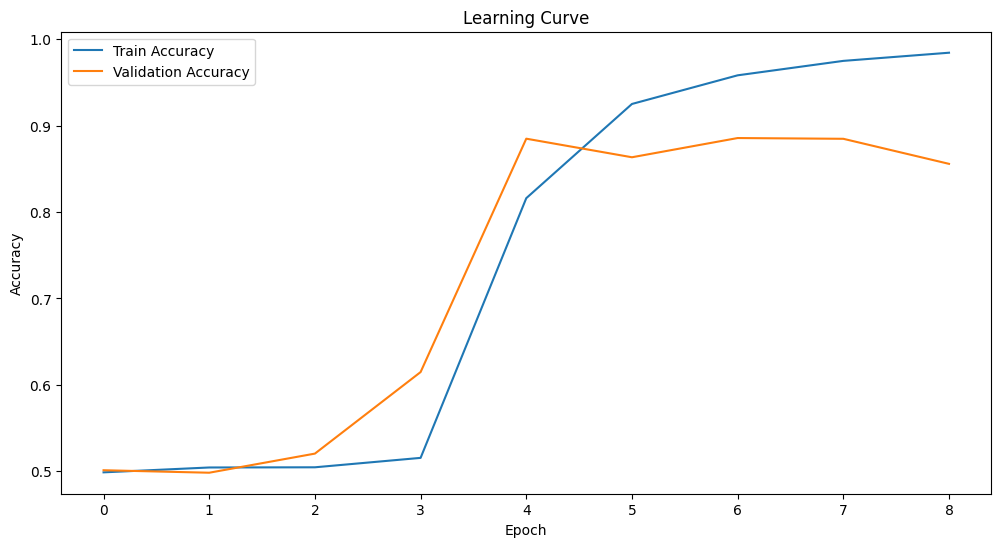

313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 84ms/step
              precision    recall  f1-score   support

           0       0.92      0.85      0.88      5000
           1       0.86      0.92      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



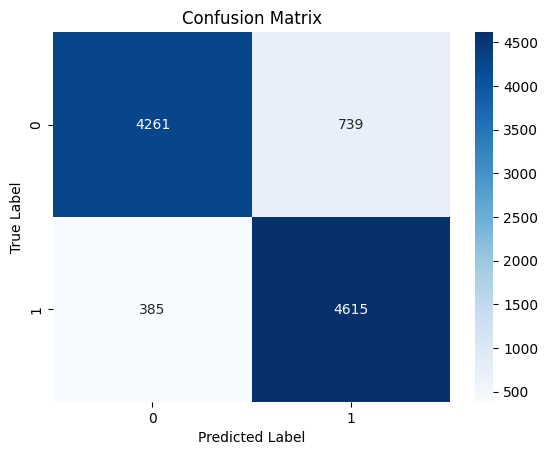


RNN Model training complete.


In [5]:
print("\nBuilding and training RNN Model...")
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
# Or if you're using the higher-level Keras API directly:
# from keras.layers import Embedding

rnn_model = Sequential([
    Embedding(max_features, 256, input_shape=(maxlen,)),
    BatchNormalization(),
    Bidirectional(LSTM(256, return_sequences=True, kernel_regularizer=regularizers.l2(0.0005), recurrent_initializer='orthogonal')),
    BatchNormalization(),
    Dropout(0.5),
    Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=regularizers.l2(0.0005), recurrent_initializer='orthogonal')),
    BatchNormalization(),
    Dropout(0.5),
    Bidirectional(LSTM(64, kernel_regularizer=regularizers.l2(0.0005), recurrent_initializer='orthogonal')),
    BatchNormalization(),

    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.0005), kernel_initializer='he_normal'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

build_and_train_model(rnn_model, x_train, y_train, x_test, y_test)

print("\nRNN Model training complete.")